In [1]:
from keras.models import load_model
import os
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [16,9]

Using TensorFlow backend.


In [2]:
from keras import backend as K

smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1. / (dice_coef(y_true, y_pred) + smooth)

In [3]:
model=load_model('base_model.h5', custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef':dice_coef})

In [4]:
ori_image_rows = 420
ori_image_cols = 580

resize_image_rows = 96
resize_image_cols = 96

def preprocess(p_path):
    images = os.listdir(p_path)
    total = len(images)
    imgs = np.ndarray((total, ori_image_rows, ori_image_cols), dtype=np.uint8)
    imgs_id = np.ndarray((total, ), dtype=object)
    print('-'*30)
    print('Creating training images...')
    print('-'*30)
    i = 0
    for image_name in images:
        img_id = image_name.split('.')[0]
        img = cv2.imread(os.path.join(p_path, image_name), cv2.IMREAD_GRAYSCALE)
        img = np.array([img])
        imgs[i] = img
        imgs_id[i] = img_id
        i += 1
        
    imgs_p = np.ndarray((imgs.shape[0], resize_image_rows, resize_image_cols), dtype=np.uint8) # Downscaling resolution
    for i in range(imgs.shape[0]): 
        imgs_p[i] = cv2.resize(imgs[i], (resize_image_cols, resize_image_rows), interpolation=cv2.INTER_CUBIC)

    imgs_p = imgs_p[..., np.newaxis]
    
    mean = 99.32807159423828
    std = 56.43379592895508
    
    imgs_p = imgs_p.astype('float32')
    imgs_p -= mean
    imgs_p /= std
    
    print('Loading done.')
    return imgs_id, imgs_p

In [56]:
def predict(path):
    img_id, imgs_p = preprocess(path)
    imgs_mask_pred = model.predict(imgs_p, verbose=0)
    pred_dir = 'new_preds'
    if not os.path.exists(pred_dir):
        os.mkdir(pred_dir)
    for image, image_id in zip(imgs_mask_pred, img_id):
        image = (image[:, :, 0] * 255.).astype(np.uint8) # Ignoring last dimension from keras output.
        image = image.astype('float32')
        image = cv2.resize(image, (ori_image_cols, ori_image_rows), interpolation=cv2.INTER_CUBIC) 
        image = cv2.threshold(image, 0.5, 1., cv2.THRESH_BINARY)[1].astype(np.uint8)
        cv2.imwrite(os.path.join(pred_dir, str(image_id) + '_mask_pred.png'), image)
    print('-' * 30)
    print('Predictions done...')
    print('-' * 30)

In [57]:
predict("/volumes/data/nerve/validation/raw")

------------------------------
Creating training images...
------------------------------
Loading done.
------------------------------
Predictions done...
------------------------------


In [62]:
raw_path = '/volumes/data/nerve/validation/raw'
true_path = '/volumes/data/nerve/validation/truth'
predicted_path = '/volumes/notebooks/nerve/new_preds'

------------------------------ Oringinal Images  ------------------------------


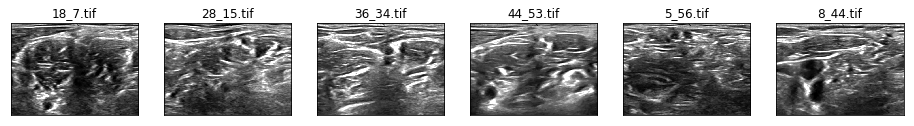

------------------------------ True labeled mask images  ------------------------------


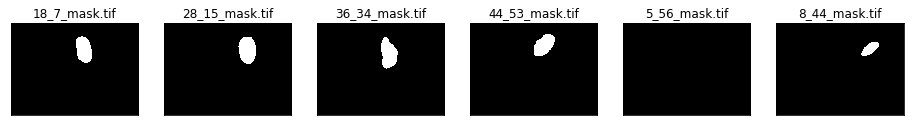

------------------------------ Predicted mask images  ------------------------------


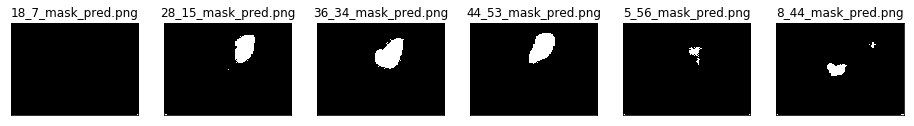

In [61]:
print('-'*30+ ' Oringinal Images  '+'-'*30)
for i, image_name in enumerate(sorted(os.listdir(raw_path))):
    img = cv2.imread(os.path.join(raw_path, image_name), cv2.IMREAD_GRAYSCALE)
    plt.subplot(1,6,i+1),plt.imshow(img, cmap='gray'), plt.title(image_name)
    plt.xticks([]), plt.yticks([])
plt.show()

print('-'*30+ ' True labeled mask images  '+'-'*30)
for i, image_name in enumerate(sorted(os.listdir(true_path))):
    img = cv2.imread(os.path.join(true_path, image_name), cv2.IMREAD_GRAYSCALE)
    plt.subplot(1,6,i+1),plt.imshow(img, cmap='gray'), plt.title(image_name)
    plt.xticks([]), plt.yticks([])
plt.show()

print('-'*30+ ' Predicted mask images  '+'-'*30)
for i, image_name in enumerate([x for x in sorted(os.listdir(predicted_path)) if 'ipynb_checkpoints' not in x]):
    img = cv2.imread(os.path.join(predicted_path, image_name), cv2.IMREAD_GRAYSCALE)
    plt.subplot(1,6,i+1),plt.imshow(img, cmap='gray'), plt.title(image_name)
    plt.xticks([]), plt.yticks([])
plt.show()